In [11]:
#Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import math
from sklearn.linear_model import LinearRegression

### Basic Functions

In [12]:
def trie(tab):  #Function that sorts an array
    tab_trie=tab.copy()
    n = len(tab)
    for i in range(n - 1):
        for j in range(n - i - 1):
            if tab_trie[j] > tab_trie[j + 1]:
                tab_trie[j], tab_trie[j + 1] = tab_trie[j + 1], tab_trie[j]
    return tab_trie

In [13]:
def mean(tab): #Fonction that calculates the mean of an array
    n=len(tab)
    return 1/n*sum(tab)

In [14]:
def sd(tab): #Fonction that calculates the standard deviation of an array
    n=len(tab)
    return np.sqrt((1/(n-1))*sum((tab-mean(tab))**2))

# Question A,B,C

In [15]:
dataNX=pd.read_csv("Natixis.txt", sep = "\t",header=None) #Data Loading

### Data Cleaning

In [16]:
# Display the shape of the DataFrame
print("Shape of natixis_Data:", dataNX.shape)

# Display the header of the DataFrame
print("\nHeader of natixis_Data:")
print(dataNX.head())

print("\nColumn names:")
print(dataNX.columns)

Shape of natixis_Data: (1023, 2)

Header of natixis_Data:
            0      1
0  02/01/2015  5,621
1  05/01/2015  5,424
2  06/01/2015  5,329
3  07/01/2015  5,224
4  08/01/2015  5,453

Column names:
Index([0, 1], dtype='int64')


In [17]:
dataNX.columns = ['Date', 'Price'] #We change the name of the columns
dataNX['Date'] = pd.to_datetime(dataNX['Date'], format='%d/%m/%Y') #We change the format of the Date
dataNX['Price'] = dataNX['Price'].str.replace(',', '.').astype(float) #We convert the prices in float
dataNX.head()

,Date,Price
0,2015-01-02,5.621
1,2015-01-05,5.424
2,2015-01-06,5.329
3,2015-01-07,5.224
4,2015-01-08,5.453


In [18]:
missing_values =dataNX.isnull().sum()
# Display the number of missing values for each column
print("Missing values by column:")
print(missing_values)

Missing values by column:
Date     0
Price    0
dtype: int64


In [19]:
dataNX['returns'] = dataNX['Price'].pct_change().fillna(0) #We add a return column to the dataset
dataNX.head()

,Date,Price,returns
0,2015-01-02,5.621,0.000000
1,2015-01-05,5.424,-0.035047
2,2015-01-06,5.329,-0.017515
3,2015-01-07,5.224,-0.019704
4,2015-01-08,5.453,0.043836


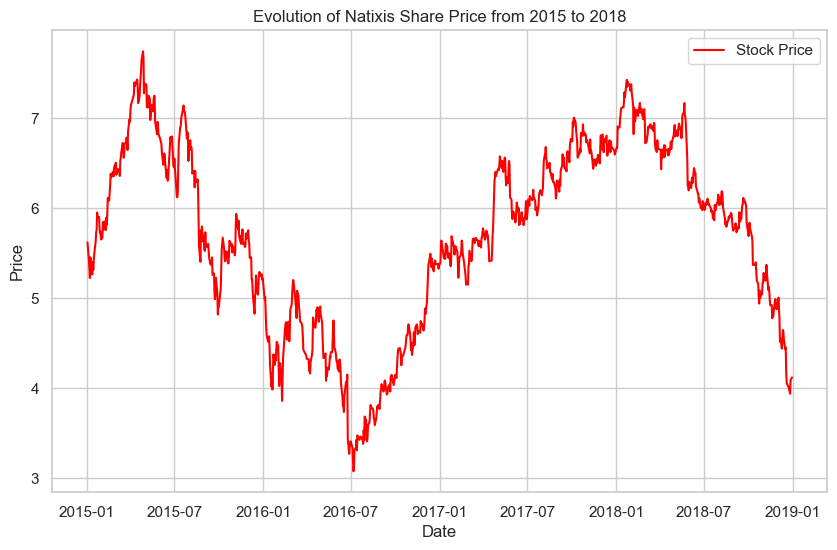

In [20]:
sns.set(style="whitegrid")
# Plot the evolution of the stock price
plt.figure(figsize=(10, 6)) 
sns.lineplot(x='Date', y='Price', data=dataNX, color='red', label='Stock Price')
# Customize the plot
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Evolution of Natixis Share Price from 2015 to 2018')
plt.legend()
plt.show()

# Question A (Ex2, part of Q1 and of Q2 of TD1) 

From the time series of the daily prices of the stock Natixis between January 2015 and December 
2016, provided with TD1, estimate a historical VaR on price returns at a one-day horizon for a given 
probability level (this probability is a parameter which must be changed easily).
You must base your VaR on a non-parametric distribution (biweight Kernel)

$K(u)=\frac{15}{16}(1-u²)² \mathbb{1}_{|u| \leq 1} $


In [21]:
alpha=0.95

In [22]:
#Array of returns between January 2015 and December 2016
nx_r1=dataNX[(dataNX['Date'] >= '2015-01-01') & (dataNX['Date'] < '2017-01-01')]['returns'].iloc[1:].values  

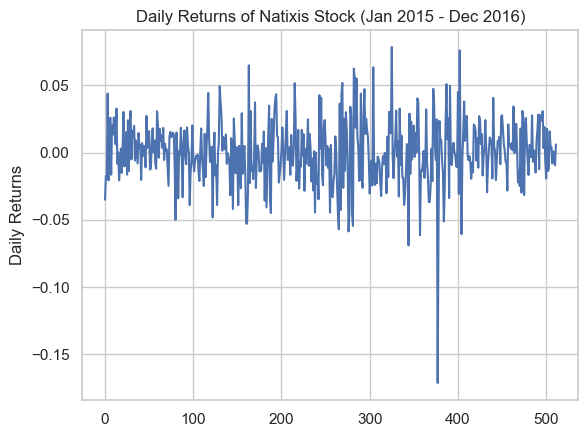

In [23]:
nx_r1_sort=trie(nx_r1)
#daily returns of the daily prices between January 2015 and December 2016
plt.plot(nx_r1)
plt.title('Daily Returns of Natixis Stock (Jan 2015 - Dec 2016)')
plt.ylabel('Daily Returns')
plt.grid(True)
plt.show()

### Empirical VaR

This function is used to compare our results with the non-parametric VaR

In [25]:
def empirical_var(returns,alpha): #Function that calculates the empirical VaR of some returns at a confidence level of alpha
    returns_sorted=trie(returns)
    n=len(returns_sorted)
    quantile=n*(1-alpha)
    return returns_sorted[int(quantile)]

In [26]:
eVaR1=empirical_var(nx_r1,alpha)
print("The empirical VaR at a confidence level of",alpha,"is",eVaR1)
print("This means that ",round(1-alpha,3)*100," % of the returns are below this value")

The empirical VaR at a confidence level of 0.95 is -0.038933559035124854
This means that  5.0  % of the returns are below this value


### VaR based on a non parametric distribution (Biweight Kernel)

In [27]:
def fkernel(x, returns, h):
    n = len(returns)
    f_x = (1/(n*h)) * sum(K((x - val)/h) for val in returns)
    return f_x

In [28]:
def Fkernel(x,returns,h):
    n=len(returns)
    f_x=(1/n)*sum(K_cdf((x - val)/h) for val in returns)
    return f_x

In [29]:
def K(x):
    if -1 <= x <= 1:
        return (15/16) * ((1 - x**2)**2)
    else:
        return 0

In [30]:
def K_cdf(x):
    if -1 <= x <= 1:
        return 1/2+x*(15/16-5*x**2/8+3*x**4/16)
    else:
        return 0

In [31]:
def non_parametric_distribution(returns,alpha):
    h=pow((4*pow(sd(returns),5))/(3*len(returns)),1/5) #Thumb formula to calculate h
    returns_trie=trie(returns)
    #Calculation of the kernel density
    x_values = np.linspace(returns_trie.min(), returns_trie.max(),1000)
    f_kernel=np.array([fkernel(x,returns,h) for x in x_values])
    
    plt.hist(returns, bins=40, density=True,edgecolor='black',alpha=0.7, color='lightgray')
    plt.plot(x_values, f_kernel, color='blue', label='Kernel density', linewidth=2)
    plt.legend()
    plt.xlabel('Daily returns')    
    plt.title("Distribution of the returns with the kernel density")
    plt.show()
    
    #Calculation of the cumulative distribution of the kernel density
    f_kernel_trie=trie(f_kernel)
    
    cumulative_kernel = np.cumsum(f_kernel) / np.sum(f_kernel_trie)
    #cumulative_kernel=np.array([Fkernel(x,returns,h) for x in x_values])
    cumulative_kernel=trie(cumulative_kernel)
    plt.plot(cumulative_kernel)
    plt.title("Cumulative Distribution of the kernel density")
    plt.xlabel("x")
    plt.ylabel("F(x)")
    plt.show()
    
    x_value = 0
    for i in range(len(cumulative_kernel)): #We take The smallest value of x such that F(x) >= alpha
        if cumulative_kernel[i] >= (1 - alpha):
            x_value = i
            break
    return x_values[i]

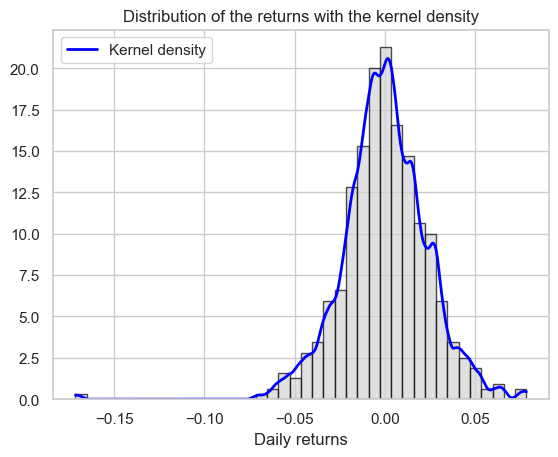

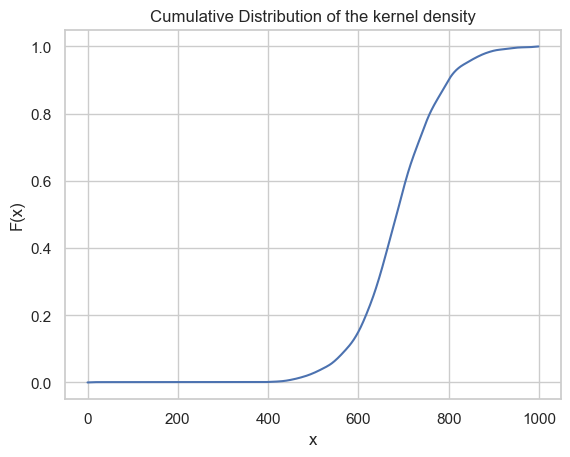

The Non Parametric VaR at a confidence level of 0.95 is -0.03782173385291748


In [32]:
npVaR=non_parametric_distribution(nx_r1,alpha)
print("The Non Parametric VaR at a confidence level of",alpha,"is",npVaR)

#### Results

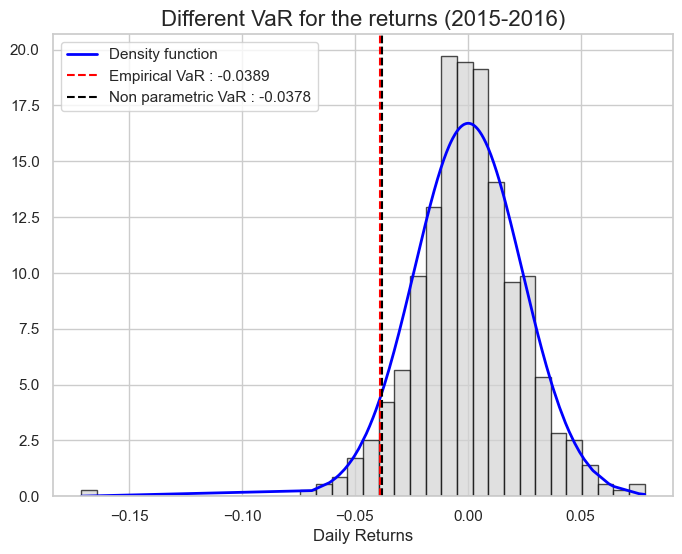

In [33]:
density = norm.pdf(nx_r1_sort, mean(nx_r1), sd(nx_r1))
plt.figure(figsize=(8,6))
plt.hist(nx_r1, density=True, bins='auto', alpha=0.7, color='lightgray', edgecolor='black')
plt.plot(nx_r1_sort, density, color='blue', label='Density function', linewidth=2)  # Affiche l'estimation de densité
plt.axvline(x=eVaR1, color='red', linestyle='dashed',label='Empirical VaR : %0.4f' % eVaR1)
plt.axvline(x=npVaR, color='black', linestyle='dashed',label='Non parametric VaR : %0.4f' % npVaR)
plt.legend()
plt.title("Different VaR for the returns (2015-2016)", fontsize=16)
plt.xlabel("Daily Returns", fontsize=12)
plt.show()

## Question A-b

Which proportion of price returns between January 2017 and December 2018 exceed the VaR 
threshold defined in the previous question? Do you validate the choice of this non-parametric VaR?

In [34]:
def test_VaR(returns,var):
    n=len(returns)
    n_inf=len(returns[returns<var])
    proportion=(n_inf/n)*100
    return proportion

#### In Sample

In [35]:
pr_eVaR1 = test_VaR(nx_r1,eVaR1)
print(pr_eVaR1, "% of price returns between January 2015 and December 2016 exceed the Empirical VaR threshold for alpha =",alpha) 

pr_npVaR1 = test_VaR(nx_r1,npVaR)
print(pr_npVaR1,"% of price returns between January 2015 and December 2016 exceed the Non Parametric VaR threshold for alpha =",alpha)

4.8828125 % of price returns between January 2015 and December 2016 exceed the Empirical VaR threshold for alpha = 0.95
5.078125 % of price returns between January 2015 and December 2016 exceed the Non Parametric VaR threshold for alpha = 0.95


#### Out of Sample

In [36]:
#Daily returns from 2017 to 2018
nx_r2=dataNX[(dataNX['Date'] >= '2017-01-01') & (dataNX['Date'] < '2019-01-01')]['returns'].iloc[1:].values 

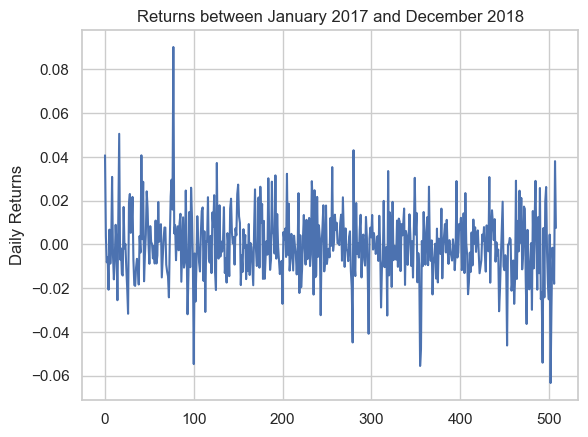

In [37]:
plt.plot(nx_r2)
plt.title("Returns between January 2017 and December 2018")
plt.ylabel('Daily Returns')
plt.show()

In [38]:
pr_eVaR2 = test_VaR(nx_r2,eVaR1)
print(pr_eVaR2, "% of price returns between January 2017 and December 2018 exceed the Empirical VaR threshold for alpha =",alpha)

pr_npVaR2 = test_VaR(nx_r2,npVaR)
print(pr_npVaR2,"% of price returns between January 2017 and December 2018 exceed the Non Parametric VaR threshold for alpha =",alpha)

1.5717092337917484 % of price returns between January 2017 and December 2018 exceed the Empirical VaR threshold for alpha = 0.95
1.5717092337917484 % of price returns between January 2017 and December 2018 exceed the Non Parametric VaR threshold for alpha = 0.95


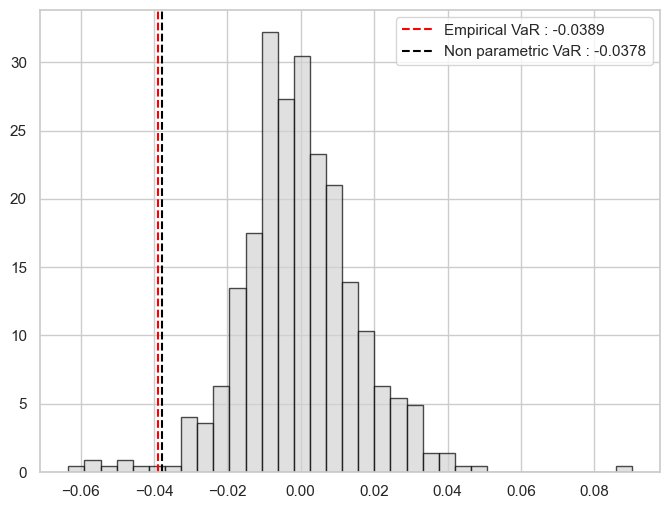

In [39]:
plt.figure(figsize=(8,6))
plt.hist(nx_r2, density=True, bins='auto', alpha=0.7, color='lightgray', edgecolor='black')
plt.axvline(x=eVaR1, color='red', linestyle='dashed',label='Empirical VaR : %0.4f' % eVaR1)
plt.axvline(x=npVaR, color='black', linestyle='dashed',label='Non parametric VaR : %0.4f' % npVaR)
plt.legend()
plt.show()

# Question B - (Ex2, Q5 of TD2) 


Calculate the expected shortfall for the VaR calculated in question A. How is the result, compared to 
the VaR? 

In [40]:
def Expected_Shortfall(returns, VaR):
    returns_sorted=trie(returns)
    return mean(returns_sorted[returns_sorted<=VaR]) #mean of the returns that exceed the VaR threshold

In [41]:
ES_eVaR1=Expected_Shortfall(nx_r1,eVaR1)
ES_npVaR=Expected_Shortfall(nx_r1,npVaR)
print("Expected Shortfall (ES) for the Empirical VaR from 2015 to 2016 is: ",ES_eVaR1 )
print("Expected Shortfall (ES) for the Non Parametric VaR from 2015 to 2016 is: ",ES_npVaR)

Expected Shortfall (ES) for the Empirical VaR from 2015 to 2016 is:  -0.05336181815045533
Expected Shortfall (ES) for the Non Parametric VaR from 2015 to 2016 is:  -0.05336181815045533


# Question C (Ex2, Q1 and Q2 of TD3) 

With the dataset provided for TD1 on Natixis prices, first calculate daily returns. You will then analyse 
these returns using a specific method in the field of the EVT. 

In [42]:
nx_returns=dataNX['returns'].iloc[1:].values 
sorted_returns=trie(nx_returns)
n=len(nx_returns)
alpha=0.95

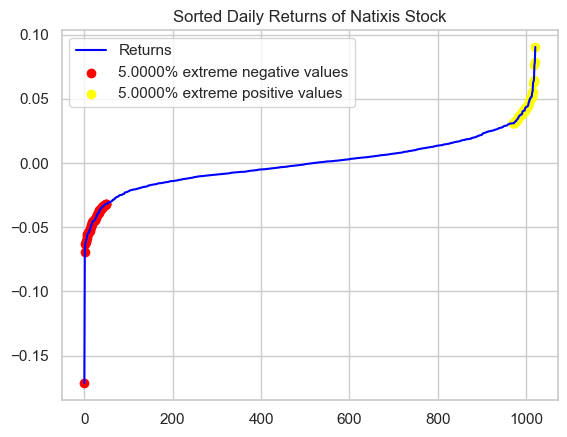

In [43]:
plt.plot(sorted_returns, color='blue', label='Returns')
plt.scatter(range(int(len(nx_returns)*(1-alpha))), sorted_returns[:int(len(nx_returns)*(1-alpha))], color='red', label='%0.4f%% extreme negative values' % ((1-alpha)*100))
plt.scatter(range(int(len(nx_returns)*(alpha)),len(nx_returns)), sorted_returns[int(len(nx_returns)*(alpha)):], color='yellow',label='%0.4f%% extreme positive values' % ((1-alpha)*100))
plt.legend()
plt.title("Sorted Daily Returns of Natixis Stock")
plt.show()

## Question a)
– Estimate the GEV parameters for the two tails of the distribution of returns, using the estimator of  Pickands. What can you conclude about the nature of the extreme gains and losses? 


In [44]:
gains=nx_returns[nx_returns>0]   
losses=-nx_returns[nx_returns<0]
losses_sorted=trie(losses)
gains_sorted=trie(gains)

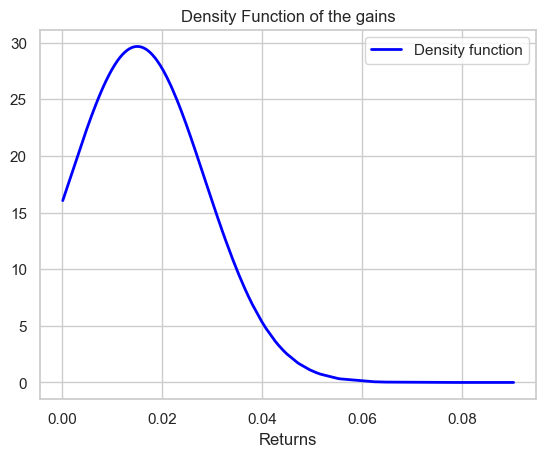

In [45]:
density = norm.pdf(gains_sorted, mean(gains), sd(gains))
plt.plot(gains_sorted, density, color='blue', label='Density function', linewidth=2)
plt.title('Density Function of the gains')
plt.xlabel('Returns')
plt.legend()
plt.show()

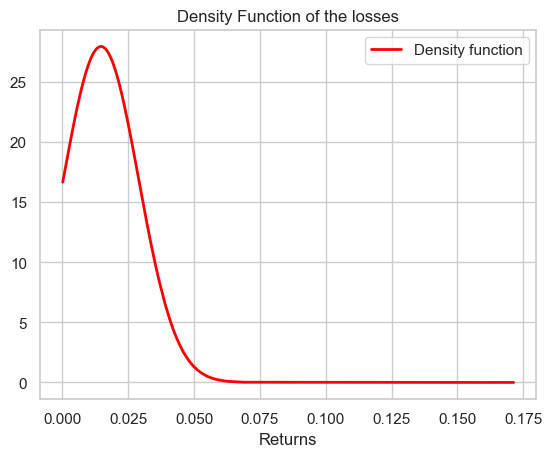

In [46]:
density = norm.pdf(losses_sorted, mean(losses), sd(losses))
plt.plot(losses_sorted, density, color='red', label='Density function', linewidth=2)
plt.title('Density Function of the losses')
plt.xlabel('Returns')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

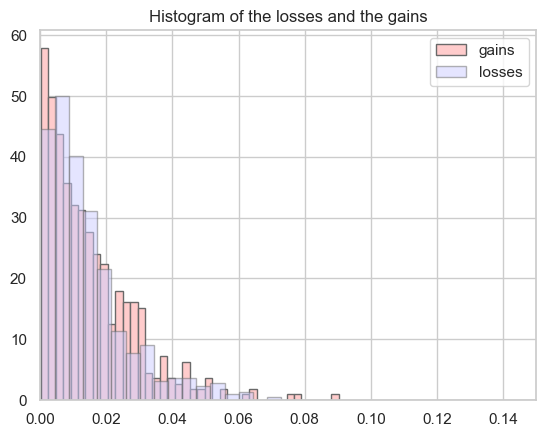

In [47]:
plt.hist(gains_sorted, bins=40, density=True,edgecolor='dimgrey',label='gains',color='#FFCCCC')
plt.hist(losses_sorted, bins=40,density=True,edgecolor='dimgrey', label='losses', alpha=0.5, color='#CCCCFF')
plt.title("Histogram of the losses and the gains")
plt.xlim(0,0.15)
plt.legend()
plt.show

### GEV Parameters using the Estimator of Pickands

Pickands Estimator : 

$ξ_{k(n), n}^P = \frac{1}{\log(2)} \log\left(\frac{X_{n-k(n)+1:n} - X_{n-2k(n)+1:n}}{X_{n-2k(n)+1:n} - X_{n-4k(n)+1:n}}\right)$

With 

$\lim_{{n \to +\infty}} k(n) = \infty$   and $\lim_{{n \to +\infty}} \frac{k(n)}{n} = 0 $


In [48]:
def pickands_estimator(data):
    data_sorted=trie(data)
    n = len(data)
    k_n = k(n)
    X_1 = data_sorted[n-math.floor(k_n)]
    X_2 = data_sorted[n-2*math.floor(k_n)]
    X_4 = data_sorted[n-4*math.floor(k_n)]
    pickands = (1/np.log(2)) * np.log((X_1-X_2)/(X_2-X_4))
    return pickands

In [49]:
def k(n):
    return np.log(n)

In [50]:
pickand_estimator_losses=pickands_estimator(losses)
pickand_estimator_gains=pickands_estimator(gains)
print("The pickand estimator for the losses of the nataxis returns is",pickand_estimator_losses)
print("The pickand estimator for the gains of the nataxis returns is",pickand_estimator_gains)

The pickand estimator for the losses of the nataxis returns is -0.5089715779341932
The pickand estimator for the gains of the nataxis returns is 0.5772338569463368


## Question b) 
– Calculate the value at risk based on EVT for various confidence levels, with the assumption of iid 
returns. 

### VaR based on EVT

$VaR(p) = \frac{\left(\frac{K}{n(1-p)}\right)^{\xi^p} - 1}{1 - 2^{-\xi^p}} \left(X_{n-k(n)+1:n} - X_{n-2k(n)+1:n}\right) + X_{n-k(n)+1:n}$

Where $ξ^P$ is the pickands estimator of the GEV parameter

In [51]:
def var_pickands_evt(data,alpha):
    data_sorted=trie(data) #so we are sure that the data is sorted
    n=len(data)
    e_pickands=np.abs(pickands_estimator(data_sorted)) #We always take the positive value of the pickands estimator
    K=1
    k_n=k(n)
    X_1=data_sorted[n-math.floor(k_n)]
    X_2=data_sorted[n-2*math.floor(k_n)]
    
    num=((K/(n*(1-alpha)))**e_pickands) - 1
    den=1-2**(-e_pickands)
    
    return (num/den)*(X_1-X_2) + X_1

In [52]:
gev_pickands_var_losses=var_pickands_evt(losses,alpha)
gev_pickands_var_gains=var_pickands_evt(gains,alpha)
print(f"GEV Pickands VaR for losses with alpha={alpha}: {gev_pickands_var_losses}")
print(f"GEV Pickands VaR for gains with alpha={alpha}: {gev_pickands_var_gains}")

GEV Pickands VaR for losses with alpha=0.95: 0.04293722770534206
GEV Pickands VaR for gains with alpha=0.95: 0.032155624020667226


In [53]:
def test_VaR2(returns,var):
    n=len(returns)
    n_inf=len(returns[returns>var])
    proportion=(n_inf/n)*100
    return proportion

In [54]:
pr_losses = test_VaR2(losses,gev_pickands_var_losses)
print(pr_losses,"% of losses exceed the Pickands VaR for alpha =",alpha)

5.009633911368015 % of losses exceed the Pickands VaR for alpha = 0.95


In [55]:
pr_gains = test_VaR2(gains,gev_pickands_var_gains)
print(pr_gains,"% of gains exceed the Pickands VaR for alpha =",alpha)

9.236947791164658 % of gains exceed the Pickands VaR for alpha = 0.95


# Question D (Ex2, Q3 and Q4 of TD4)

### Data cleaning 

In [57]:
data = pd.read_excel("Ds_TD4.xlsx")

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

In [56]:
new_columns = {
    'transaction date (1=1day=24 hours)': 'Date',
    'bid-ask spread': 'bid_ask_spread',
    'volume of the transaction (if known)': 'Volume',
    'Sign of the transaction': 'Sign',
    'Price (before transaction)':'Price'
}
# Rename the columns
data.rename(columns=new_columns, inplace=True)
data['Volume'].fillna(0,inplace=True)
data=data[data['Volume']>0]

NameError: name 'data' is not defined

In [47]:
print(data.head())
print(len(data))

        Date  bid_ask_spread  Volume  Sign    Price
0   0.000202          0.1100     8.0    -1  100.000
6   0.004074          0.1294    32.0     1  100.164
16  0.014393          0.1141     8.0    -1  100.048
28  0.022861          0.0978   141.0    -1   99.876
51  0.037864          0.1291   121.0    -1   99.608
137


## a) Almgren and Chriss model

Estimate all the parameters of the model of Almgren and Chriss. Is this model well specified? 


$ 
\sum_{k=1}^{N} n_k \overline{S_k} = XS_0 + \sum_{k=1}^{N}[(σ\sqrt{τ}ε_k - τg(\frac{n_k}{τ}))x_k - n_kh(\frac{n_k}{τ}])
 $

$X$ : total Amount liquidated  

$S_0$ : inital market Price before the beginning of the liquidation  

$X*S_0$: liquidation price of X if we liquidate at once  

$n_1,..,n_n = N $ Slices of liquidation $\sum_{k=1}^{N}n_k=X $  

$t_1=\frac{1}{n},...,t_n=\frac{N}{N}$  liquidation time 

$x_k=X-\sum_{j=1}^{K}n_j$ remaining volume to be liquidated at time k  
  
$τ=t_k-t_{k-1} =  \frac{1}{24}$  

$ \varepsilon_k \sim \mathcal{N}(0, 1)$

$\sigma = $ market volatility  

$v_k=\frac{n_k}{τ} = $ liquidation speed of the slice $n_k$  

g is the **permanent impact function** $g(v_k)=\gamma v_k$

$\sigma \sqrt{τ} \varepsilon_k = $ market risk related to the market movements  

$ τg(\frac{n_k}{τ})= $ **permanent impact** related to the liquidation of the (K-1) previous slices   

$\overline{S_k}=S_k-h(\frac{n_k}{τ})$ : **transient impact** related to the liquidation of the Kth slice. Resorbed at the end of the time step τ and does not affect the next liquidation

where $h(\frac{n_k}{τ})=\xi sgn(n_k)+ ŋ\frac{n_k}{τ}$  

$
\text{sgn}(n_k) = \begin{cases} 
+1 & \text{if } n_k \text{ is a purchase} \\
-1 & \text{if } n_k \text{ is a sale}
\end{cases}
$   

$\xi = $ Bid-Ask spread




In [48]:
X=1000
S0=data['Price'][0]
to=1/24

We need to calculte ŋ, σ, γ

#### Calculation of the returns

In [49]:
data['returns'] = ((data['Price'] / data['Price'].shift(1)) - 1) * np.sqrt(1 / (data['Date'] - data['Date'].shift(1)))
#data['returns'] = ((data['Price'] / data['Price'].shift(1)) - 1) 
returns = np.array(data['returns'].iloc[1:])
data.head()

,Date,bid_ask_spread,Volume,Sign,Price,returns
0,0.000202,0.1100,8.0,-1,100.000,NaN
6,0.004074,0.1294,32.0,1,100.164,0.026356
16,0.014393,0.1141,8.0,-1,100.048,-0.011401
28,0.022861,0.0978,141.0,-1,99.876,-0.018682
51,0.037864,0.1291,121.0,-1,99.608,-0.021907


#### Calculation of the standard deviation

In [50]:
mu=mean(returns)
sigma=sd(returns)
print(mu)
print(sigma)

0.0005251700566445208
0.034144713194463064


### Calculation of γ
 $g(v_k)=γ*v_k$ with $v_k=\frac{n_k}{τ}$

**Permanent impact** = $g(v_k) = P_{t+2}-P_t$

In [51]:
permanent_impact=[]
time=[]
for i in range(2,len(data)):
    permanent_impact.append(data['Price'].iloc[i]-data['Price'].iloc[i-2])
    time.append(data['Date'].iloc[i]-data['Date'].iloc[i-2])
permanent_impact=np.array(permanent_impact)
time=np.array(time)

In [52]:
nk=np.array(data['Volume'])
nk=nk[:-2]
vk=nk/time

In [53]:
def LinearRegression(x,y):
    return np.sum((x - mean(x)) * (y - mean(y)))/np.sum((x - mean(x))**2)

In [54]:
gamma=LinearRegression(vk,permanent_impact)
print(f"Estimated gamma : {gamma}")

Estimated gamma : 2.714276160923749e-07


### Estimation of ŋ

$h(\frac {nk}{τ})=\xi sgn(n_k) + ŋ(\frac{n_k}{τ})$

$
\text{sgn}(n_k) = \begin{cases} 
+1 & \text{if } n_k \text{ is a purchase} \\
-1 & \text{if } n_k \text{ is a sale}
\end{cases}
$   

$\xi = $ Bid-Ask spread

$h(\frac{n_k}{τ})=P_{t+1}-P_{t+2} =\text{transient impact} $

We carry a linear regression of $h(\frac{n_k}{τ}) - \xi sgn(n_k)$ in order to estimate ŋ : 

In [55]:
t=[]
Xi=np.array(data['bid_ask_spread']/2) #Bid Ask spread/2
sgn=np.array(data['Sign']) #Sign of the transaction
transient_impact=[]
for i in range(2,len(data)):
    t.append(data['Date'].iloc[i]-data['Date'].iloc[i-1])  
    transient_impact.append(data['Price'].iloc[i-1]-data['Price'].iloc[i])  #Pt+1-Pt+2
    
t=np.array(t)
transient_impact=np.array(transient_impact)
Xi=Xi[:-2]
sgn=sgn[:-2]
Y=transient_impact-Xi*sgn
vk=nk/t

In [56]:
nu=LinearRegression(vk,Y)
print(f"Estimated ŋ : {nu}")

Estimated ŋ : -1.4168633631897494e-09


## b) Optimal Strategy of liquidation with the AC model

In the framework of Almgren and Chriss, what is your liquidation strategy (we recall that you can 
only make transactions once every hour).

$x_k^*=\frac{sinh(K(T-(k-\frac{1}{2}τ)))}{sinh(KT)} X$   

where $K \overset{\tau \to 0}{\sim} \sqrt{\frac{\lambda \sigma^2}{\eta}} + O(\tau)$

In [57]:
l=0.01
T=24
to=1/24
X=1000

In [58]:
def xk_values(sigma, mu,l,X,T,to):
    xk = np.zeros(24)
    K = np.sqrt(l * (sigma**2) / abs(mu))   #Calculate K
    for i in range(24):
        xk[i] = (np.sinh(K*(T- (i + 1/2*to)))/np.sinh(K*T))*X 
    return xk

In [59]:
xk=xk_values(sigma,mu,l,X,T,to)
xk_1=xk_values(sigma,mu,0.1,X,T,to)
xk_2=xk_values(sigma,mu,0.5,X,T,to)
xk_3=xk_values(sigma,mu,1,X,T,to)
xk_4=xk_values(sigma,mu,0.001,X,T,to)

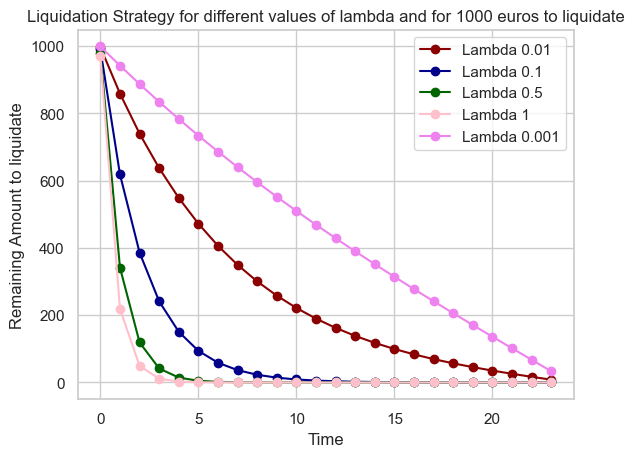

In [60]:
plt.plot(range(0, 24), xk, marker='o', linestyle='-', color='darkred', label='Lambda 0.01')
plt.plot(range(0, 24), xk_1, marker='o', linestyle='-', color='darkblue', label='Lambda 0.1')
plt.plot(range(0, 24), xk_2, marker='o', linestyle='-', color='darkgreen', label='Lambda 0.5')
plt.plot(range(0, 24), xk_3, marker='o', linestyle='-', color='pink', label='Lambda 1')
plt.plot(range(0, 24), xk_4, marker='o', linestyle='-', color='violet', label='Lambda 0.001')
plt.xlabel('Time')
plt.ylabel('Remaining Amount to liquidate')
plt.title(f'Liquidation Strategy for different values of lambda and for {X} euros to liquidate')
plt.grid(True)
plt.legend()  
plt.show()

# Question E (Q4 of TD5) 

In [61]:
data_TD5= pd.read_excel("Dataset TD5.xlsx",header=2)
data_TD5.set_index('Date', inplace=True)
data_TD5.index = pd.to_datetime(data_TD5.index)


GBPEUR = data_TD5.iloc[:, 0:2]
GBPEUR['Mid Price'] = (GBPEUR['HIGH'] + GBPEUR['LOW']) / 2

SEKEUR = data_TD5.iloc[:, 4:6]
SEKEUR['Mid Price'] = (SEKEUR['HIGH.1'] + SEKEUR['LOW.1']) / 2

CADEUR = data_TD5.iloc[:, 8:11]
CADEUR['Mid Price'] = (CADEUR['HIGH.2'] + CADEUR['LOW.2']) / 2

print("GBPEUR dataset :\n", GBPEUR.head())
print("\nSEKEUR dataset :\n", SEKEUR.head())
print("\nCADEUR dataset :\n", CADEUR.head())

GBPEUR dataset :
                            HIGH     LOW  Mid Price
Date                                              
2016-03-07 08:59:59.990  1.2932  1.2917    1.29245
2016-03-07 09:15:00.000  1.2940  1.2930    1.29350
2016-03-07 09:30:00.000  1.2943  1.2922    1.29325
2016-03-07 09:45:00.000  1.2930  1.2913    1.29215
2016-03-07 10:00:00.000  1.2931  1.2921    1.29260

SEKEUR dataset :
                           HIGH.1    LOW.1  Mid Price
Date                                                
2016-03-07 08:59:59.990  0.10725  0.10720   0.107225
2016-03-07 09:15:00.000  0.10728  0.10717   0.107225
2016-03-07 09:30:00.000  0.10726  0.10719   0.107225
2016-03-07 09:45:00.000  0.10728  0.10721   0.107245
2016-03-07 10:00:00.000  0.10725  0.10719   0.107220

CADEUR dataset :
                          HIGH.2   LOW.2  Mid Price
Date                                              
2016-03-07 08:59:59.990  0.6842  0.6829    0.68355
2016-03-07 09:15:00.000  0.6849  0.6841    0.68450
2016-03-07 0

With the dataset provided for TD5, build a portfolio containing the three FX rates, with equal weights. 
Determine the volatility of this portfolio for different time scales (from 15 minutes to roughly 1 week) 
using two different methods: 


## Question E-a.1)
– Determine the correlation matrix at each scale using wavelets. 

In [62]:
def haar_father_wavelet(t):
    return np.where((0 <= t) & (t <= 1), 1.0, 0.0)

In [63]:
def haar_son_wavelet(j, k, t):
    return 2**(j/2) * haar_father_wavelet(2**j * t - k)

STEP 1 : Compute for each j the time scale the geometrical returns of the portfolio

In [64]:
# Time Scale
#j = pd.Timedelta(minutes=15)
#j = pd.Timedelta(hours=1)
#j = pd.Timedelta(hours=16)
j= pd.Timedelta(days=3)
#j = pd.Timedelta(weeks=1)

# Calculer les rendements géométriques pour chaque taux de change
GBPEUR['geo_returns'] = (GBPEUR['Mid Price'] - GBPEUR['Mid Price'].shift(freq=j)) / GBPEUR['Mid Price'].shift(freq=j)
SEKEUR['geo_returns'] = (SEKEUR['Mid Price'] - SEKEUR['Mid Price'].shift(freq=j)) / SEKEUR['Mid Price'].shift(freq=j)
CADEUR['geo_returns'] = (CADEUR['Mid Price'] - CADEUR['Mid Price'].shift(freq=j)) / CADEUR['Mid Price'].shift(freq=j)

print("GBPEUR :\n", GBPEUR.head())
print("\nSEKEUR dataset :\n", SEKEUR.head())
print("\nCADEUR dataset :\n", CADEUR.head())

T = GBPEUR['geo_returns'].index[-1] - GBPEUR['geo_returns'].index[0]
print(f"\n T difference is : {T}")

GBPEUR.dropna(subset=['geo_returns'], inplace=True)
SEKEUR.dropna(subset=['geo_returns'], inplace=True)
CADEUR.dropna(subset=['geo_returns'], inplace=True)

print("GBPEUR :\n", GBPEUR.head())
print("\nSEKEUR :\n", SEKEUR.head())
print("\nCADEUR dataset :\n", CADEUR.head())

GBPEUR :
                            HIGH     LOW  Mid Price  geo_returns
Date                                                           
2016-03-07 08:59:59.990  1.2932  1.2917    1.29245          NaN
2016-03-07 09:15:00.000  1.2940  1.2930    1.29350          NaN
2016-03-07 09:30:00.000  1.2943  1.2922    1.29325          NaN
2016-03-07 09:45:00.000  1.2930  1.2913    1.29215          NaN
2016-03-07 10:00:00.000  1.2931  1.2921    1.29260          NaN

SEKEUR dataset :
                           HIGH.1    LOW.1  Mid Price  geo_returns
Date                                                             
2016-03-07 08:59:59.990  0.10725  0.10720   0.107225          NaN
2016-03-07 09:15:00.000  0.10728  0.10717   0.107225          NaN
2016-03-07 09:30:00.000  0.10726  0.10719   0.107225          NaN
2016-03-07 09:45:00.000  0.10728  0.10721   0.107245          NaN
2016-03-07 10:00:00.000  0.10725  0.10719   0.107220          NaN

CADEUR dataset :
                          HIGH.2   LOW.2  M

STEP 2 : Compute the scaling coefficients $c_{j,k}$

In [83]:
def scaling_coefficient(geo_return, j,k, dt=0.01):
    # Conversion of min and max in days
    min_date = geo_return.index.min()
    max_date = geo_return.index.max()

    # Calculate the difference in days
    min_date_days = (min_date - min_date).days
    max_date_days = (max_date - min_date).days

    t_values = np.arange(min_date_days, max_date_days, dt).astype(int)

    coefficients = geo_return.iloc[t_values] * haar_son_wavelet(j,k, t_values) * dt

    # Sum of the coefficients
    c_jk = np.sum(coefficients)

    return c_jk

def scaling_coefficient_mean(geo_returns, j):
    # Calculation of T, the difference between the first and last day of the index
    T = geo_returns.index[-1] - geo_returns.index[0]
    T_days = T.days

    k_values = np.arange(1, int(T.days / j))

    scaling_coef_values = np.array([scaling_coefficient(geo_returns, j, k) for k in k_values])

    c_j = (j / T_days) * np.sum(scaling_coef_values)

    return c_j

STEP 3 : Compute the correlation matrix

In [66]:
def calculate_covariance(geo_returns1, geo_returns2, j):
    scaling_coef_mean_1 = scaling_coefficient_mean(geo_returns1, j)
    scaling_coef_mean_2 = scaling_coefficient_mean(geo_returns2, j)

    T_days = (geo_returns1.index[-1] - geo_returns1.index[0]).days
    k_values = np.arange(1, int(T_days / j))

    c_j1 = np.array([scaling_coefficient(geo_returns1, j, k) for k in k_values]) - scaling_coef_mean_1
    c_j2 = np.array([scaling_coefficient(geo_returns2, j, k) for k in k_values]) - scaling_coef_mean_2

    covariance = (j / T_days) * np.sum(c_j1 * c_j2)
    return covariance

In [67]:
def calculate_variance(geo_returns, j):
    scaling_coef_mean = scaling_coefficient_mean(geo_returns, j)
    T_days = (geo_returns.index[-1] - geo_returns.index[0]).days
    k_values = np.arange(1, int(T_days / j))

    c_j = np.array([scaling_coefficient(geo_returns, j, k) for k in k_values])

    variance = (j / T_days) * np.sum((c_j - scaling_coef_mean) ** 2)
    return variance

In [68]:
def calculate_correlation(geo_returns1, geo_returns2, j):
    covariance = calculate_covariance(geo_returns1, geo_returns2, j)
    variance1 = calculate_variance(geo_returns1, j)
    variance2 = calculate_variance(geo_returns2, j)

    correlation = covariance / (np.sqrt(variance1) * np.sqrt(variance2))
    return correlation

In [69]:
# Initialisation of the correlation matrix
correlation_matrix = pd.DataFrame(index=['GBPEUR', 'SEKEUR', 'CADEUR'], columns=['GBPEUR', 'SEKEUR', 'CADEUR'])

geo_returns_list = [
    GBPEUR['geo_returns'],
    SEKEUR['geo_returns'],
    CADEUR['geo_returns']
]

j = round(j.days+j.seconds / (24 * 60 * 60),2)

# Calculation of the correlation matrix
for i in range(len(geo_returns_list)):
    for l in range(len(geo_returns_list)):
        if i == l:
            correlation_matrix.iloc[i, l] = 1
        else:
            correlation_value = calculate_correlation(geo_returns_list[i], geo_returns_list[l], j)
            correlation_matrix.iloc[i, l] = correlation_value

print(correlation_matrix)

          GBPEUR    SEKEUR    CADEUR
GBPEUR         1  0.982187  0.988925
SEKEUR  0.982187         1  0.996278
CADEUR  0.988925  0.996278         1


## Question E-a.2 
Determine the volatility vector with a scaling thanks to the Hurst exponents. From the correlation matrix and the volatility vector, calculate the covariance matrix and conclude about the volatility of the portfolio.

STEP 1 : Estimate the Hurst exponent

In [70]:
def estimate_hurst_exponent(mid_price, j):
    
    geo_returns_j = (mid_price - mid_price.shift(freq=j)) / mid_price.shift(freq=j)
    geo_returns_2j = (mid_price - mid_price.shift(freq=2 * j)) / mid_price.shift(freq=2 * j)

    geo_returns_j = geo_returns_j.dropna()
    geo_returns_2j = geo_returns_2j.dropna()

    T = geo_returns_j.index[-1] - geo_returns_j.index[0]
    T_days = T.days
    j_days = j.days + j.seconds / (24 * 60 * 60)

    N = T_days / j_days

    indices_j = np.arange(0, len(geo_returns_j), max(1, int(j_days)))
    indices_2j = np.arange(0, len(geo_returns_2j), max(1, int(2 * j_days)))

    if len(indices_j) > 0:
        sum_M2 = np.sum([geo_returns_j[i]**2 for i in indices_j])
        M2 = sum_M2 / N
    else:
        M2 = 0.0

    if len(indices_2j) > 0:
        sum_M2_prime = np.sum([geo_returns_2j[i]**2 for i in indices_2j])
        M2_prime = sum_M2_prime / (N // 2)
    else:
        M2_prime = 0.0

    hurst_exponent = 0.5 * np.log2(M2_prime / M2)

    return hurst_exponent

In [71]:
j= pd.Timedelta(days=3)
#j = pd.Timedelta(hours=1)

hurst_value_GBP = estimate_hurst_exponent(GBPEUR['Mid Price'], j)
hurst_value_SEK = estimate_hurst_exponent(SEKEUR['Mid Price'], j)
hurst_value_CAD = estimate_hurst_exponent(CADEUR['Mid Price'], j)

hurst_value_list = [
    hurst_value_GBP,
    hurst_value_SEK,
    hurst_value_CAD
]


print("Hurst Exponent for GBPEUR:", hurst_value_GBP)
print("Hurst Exponent for SEKEUR:", hurst_value_SEK)
print("Hurst Exponent for CADEUR:", hurst_value_CAD)

Hurst Exponent for GBPEUR: 0.09946766603778082
Hurst Exponent for SEKEUR: 0.10340084082614123
Hurst Exponent for CADEUR: -0.018450943720438564


C:\Users\bapdu\AppData\Local\Temp\ipykernel_24648\2532626269.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum_M2 = np.sum([geo_returns_j[i]**2 for i in indices_j])
C:\Users\bapdu\AppData\Local\Temp\ipykernel_24648\2532626269.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum_M2_prime = np.sum([geo_returns_2j[i]**2 for i in indices_2j])


STEP 2 : Calculate the volatility

In [72]:
def adjusted_volatility(hurst_exponent, geo_returns,j):
    j_days=j.days+ j.seconds / (24 * 60 * 60)
    ecart_type = geo_returns.std()

    adjusted_vol_j = (j_days / 256) ** hurst_exponent * (256) ** hurst_exponent * ecart_type

    return adjusted_vol_j

STEP 3 : Calculate the Volatility vector

In [73]:
#j = pd.Timedelta(days=3)

# Calcul de la volatilité ajustée pour chaque devise
volatility_adjusted = [adjusted_volatility(hurst_value_list[i], geo_returns_list[i], j) for i in range(len(geo_returns_list))]

# Affichage des volatilités ajustées pour chaque devise
for i, vol in enumerate(volatility_adjusted):
    print(f"Adjusted volatility for the serie {i+1}: {vol}")

Adjusted volatility for the serie 1: 0.013099282070829372
Adjusted volatility for the serie 2: 0.005407767760202877
Adjusted volatility for the serie 3: 0.007869598636978618


In [74]:
# Initialisation of the covariance matrix
covariance_matrix = pd.DataFrame(index=['GBPEUR', 'SEKEUR', 'CADEUR'], columns=['GBPEUR', 'SEKEUR', 'CADEUR'])

geo_returns_list = [
    GBPEUR['geo_returns'],
    SEKEUR['geo_returns'],
    CADEUR['geo_returns']
]

j = j.days+ j.seconds / (24 * 60 * 60)

# Calculation of the correlation matrix
for i in range(len(geo_returns_list)):
    for l in range(len(geo_returns_list)):
        if i == l:
            covariance_matrix.iloc[i, l] = calculate_variance(geo_returns_list[l],j)
        else:
            covariance_value = calculate_covariance(geo_returns_list[i], geo_returns_list[l], j)
            covariance_matrix.iloc[i, l] = covariance_value

print(covariance_matrix)

          GBPEUR    SEKEUR    CADEUR
GBPEUR  0.000012  0.000021  0.000024
SEKEUR  0.000021  0.000037  0.000042
CADEUR  0.000024  0.000042  0.000049


In [75]:
w=np.array([1/3,1/3,1/3])

In [76]:
Vol_ptf=np.sqrt(w@covariance_matrix@w.T)
print(f"The volatility of the portfolio for j = {j} day(s) is {Vol_ptf}")

The volatility of the portfolio for j = 3.0 day(s) is 0.0055017614660233475


## Question b 
– Determine the volatility directly from the series of prices of the portfolio and justify your methodological choices (for example with overlapping returns or not).

STEP 1 : Compute for each j the time scale the geometrical returns of the portfolio

In [77]:
# Time Scale
#j = pd.Timedelta(minutes=15)
#j = pd.Timedelta(hours=1)
#j = pd.Timedelta(hours=16)
j= pd.Timedelta(days=3)
#j = pd.Timedelta(weeks=1)

# Calculer les rendements géométriques pour chaque taux de change
GBPEUR['geo_returns'] = (GBPEUR['Mid Price'] - GBPEUR['Mid Price'].shift(freq=j)) / GBPEUR['Mid Price'].shift(freq=j)
SEKEUR['geo_returns'] = (SEKEUR['Mid Price'] - SEKEUR['Mid Price'].shift(freq=j)) / SEKEUR['Mid Price'].shift(freq=j)
CADEUR['geo_returns'] = (CADEUR['Mid Price'] - CADEUR['Mid Price'].shift(freq=j)) / CADEUR['Mid Price'].shift(freq=j)

print("Premier dataset :\n", GBPEUR.head())
print("\nDeuxième dataset :\n", SEKEUR.head())
print("\nTroisième dataset :\n", CADEUR.head())


Premier dataset :
                        HIGH     LOW  Mid Price  geo_returns
Date                                                       
2016-03-10 09:15:00  1.2961  1.2947    1.29540          NaN
2016-03-10 09:30:00  1.2971  1.2957    1.29640          NaN
2016-03-10 09:45:00  1.2972  1.2964    1.29680          NaN
2016-03-10 10:00:00  1.2971  1.2963    1.29670          NaN
2016-03-10 10:15:00  1.2966  1.2949    1.29575          NaN

Deuxième dataset :
                       HIGH.1    LOW.1  Mid Price  geo_returns
Date                                                         
2016-03-10 09:15:00  0.10773  0.10767   0.107700          NaN
2016-03-10 09:30:00  0.10770  0.10767   0.107685          NaN
2016-03-10 09:45:00  0.10780  0.10770   0.107750          NaN
2016-03-10 10:00:00  0.10781  0.10775   0.107780          NaN
2016-03-10 10:15:00  0.10784  0.10777   0.107805          NaN

Troisième dataset :
                      HIGH.2   LOW.2  Mid Price  geo_returns
Date                    

In [78]:
# Calculer la somme des valeurs NaN dans la colonne 'geo_returns' de GBPEUR
sum_nan_GBPEUR = GBPEUR['geo_returns'].isna().sum()
print(sum_nan_GBPEUR)

2551


In [79]:
# Calculer la différence entre les dates consécutives
time_diff = GBPEUR.index.to_series().diff()

# Trouver les indices où la différence n'est pas de 15 minutes
incorrect_intervals = time_diff[time_diff != pd.Timedelta(minutes=15)]

# Afficher les indices et les écarts
for index in incorrect_intervals.index:
    print(f"Index: {index}, Différence: {incorrect_intervals[index]}")

#Ca correspond au weekend

Index: 2016-03-10 09:15:00, Différence: NaT
Index: 2016-03-13 19:00:00, Différence: 1 days 20:15:00
Index: 2016-03-16 19:00:00, Différence: 1 days 20:15:00
Index: 2016-03-20 19:00:00, Différence: 1 days 21:15:00
Index: 2016-03-23 19:00:00, Différence: 1 days 21:15:00
Index: 2016-03-27 20:00:00, Différence: 1 days 22:15:00
Index: 2016-03-30 20:00:00, Différence: 1 days 22:15:00
Index: 2016-04-03 21:00:00, Différence: 1 days 22:15:00
Index: 2016-04-06 21:00:00, Différence: 1 days 22:15:00
Index: 2016-04-10 21:00:00, Différence: 1 days 22:15:00
Index: 2016-04-13 21:00:00, Différence: 1 days 22:15:00
Index: 2016-04-17 21:00:00, Différence: 1 days 22:15:00
Index: 2016-04-20 21:00:00, Différence: 1 days 22:15:00
Index: 2016-04-24 21:00:00, Différence: 1 days 22:15:00
Index: 2016-04-27 21:00:00, Différence: 1 days 22:15:00
Index: 2016-05-01 21:00:00, Différence: 1 days 22:15:00
Index: 2016-05-04 21:00:00, Différence: 1 days 22:15:00
Index: 2016-05-08 21:00:00, Différence: 1 days 22:15:00
Inde

In [80]:
GBPEUR.dropna(subset=['geo_returns'], inplace=True)
SEKEUR.dropna(subset=['geo_returns'], inplace=True)
CADEUR.dropna(subset=['geo_returns'], inplace=True)

print("Premier dataset :\n", GBPEUR.head())
print("\nDeuxième dataset :\n", SEKEUR.head())
print("\nTroisième dataset :\n", CADEUR.head())

Premier dataset :
                        HIGH     LOW  Mid Price  geo_returns
Date                                                       
2016-03-13 19:00:00  1.2917  1.2900    1.29085     0.011281
2016-03-13 19:15:00  1.2921  1.2892    1.29065     0.011164
2016-03-13 19:30:00  1.2905  1.2884    1.28945     0.010660
2016-03-13 19:45:00  1.2901  1.2889    1.28950     0.011016
2016-03-13 20:00:00  1.2919  1.2898    1.29085     0.012352

Deuxième dataset :
                       HIGH.1    LOW.1  Mid Price  geo_returns
Date                                                         
2016-03-13 19:00:00  0.10750  0.10735   0.107425     0.005523
2016-03-13 19:15:00  0.10754  0.10725   0.107395     0.005524
2016-03-13 19:30:00  0.10753  0.10743   0.107480     0.005426
2016-03-13 19:45:00  0.10758  0.10740   0.107490     0.005331
2016-03-13 20:00:00  0.10753  0.10747   0.107500     0.006272

Troisième dataset :
                      HIGH.2   LOW.2  Mid Price  geo_returns
Date                    

In [81]:
ptf = pd.DataFrame(index=GBPEUR.index)

ptf['GBPEUR_geo_returns'] = GBPEUR['geo_returns']
ptf['SEKEUR_geo_returns'] = SEKEUR['geo_returns']
ptf['CADEUR_geo_returns'] = CADEUR['geo_returns']

ptf['Average_geo_returns'] = ptf.mean(axis=1)

print(ptf.head())

                     GBPEUR_geo_returns  SEKEUR_geo_returns  \
Date                                                          
2016-03-13 19:00:00            0.011281            0.005523   
2016-03-13 19:15:00            0.011164            0.005524   
2016-03-13 19:30:00            0.010660            0.005426   
2016-03-13 19:45:00            0.011016            0.005331   
2016-03-13 20:00:00            0.012352            0.006272   

                     CADEUR_geo_returns  Average_geo_returns  
Date                                                          
2016-03-13 19:00:00            0.017005             0.011270  
2016-03-13 19:15:00            0.016472             0.011053  
2016-03-13 19:30:00            0.014806             0.010297  
2016-03-13 19:45:00            0.014276             0.010208  
2016-03-13 20:00:00            0.015627             0.011417  


STEP 2 : Compute the empirical variance of these returns

In [82]:
ptf['Squared_Average_geo_returns'] = ptf['Average_geo_returns'] ** 2
T = GBPEUR['geo_returns'].index[-1] - GBPEUR['geo_returns'].index[0]
T_days = T.days
j_days=j.days+ j.seconds / (24 * 60 * 60)
N = T_days/j_days
M2_j = ptf['Squared_Average_geo_returns'].sum()/N

print(f"The empirical variance M^2(j) is: {M2_j}")

vol = np.sqrt(M2_j)

print(f"The volatility (vol) for j = {j} is: {vol}")

The empirical variance M^2(j) is: 0.0032696262551153033
The volatility (vol) for j = 3 days 00:00:00 is: 0.05718064580883381
